# Importing library


In [27]:
from torchvision import transforms,datasets
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import nn

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

In [29]:
# Data augmentation
transform_train = transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.225])
])
transform_test = transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.225]) #because image is grayscale
])

In [30]:
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   download=True,
                                   transform=transform_train)

test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  download=True,
                                  transform=transform_test)

In [31]:
# set the shape
image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [32]:
# see class
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Visualize data


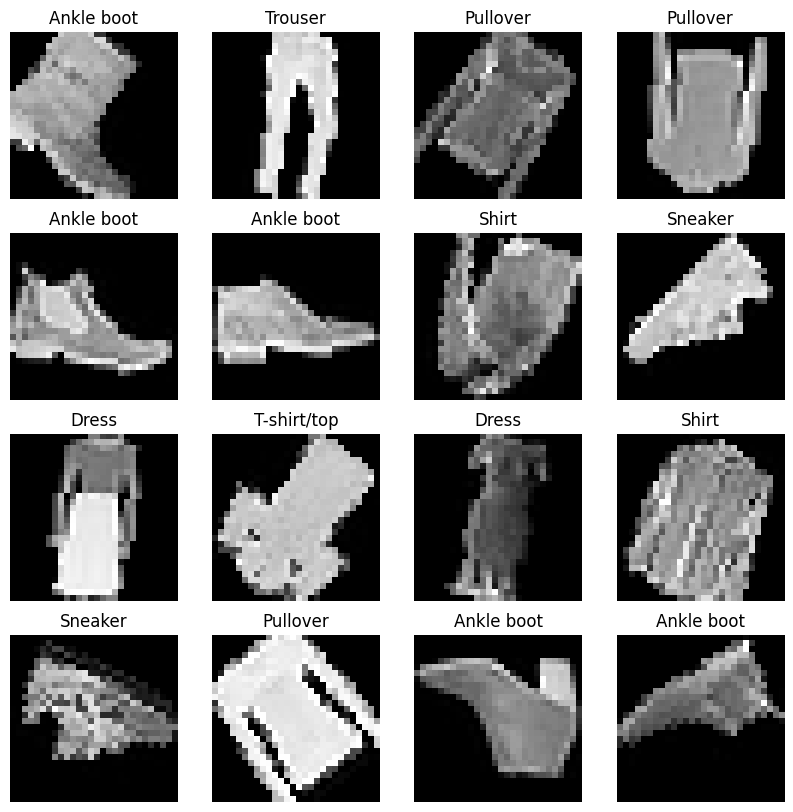

In [33]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10,10))
rows, cols = 4,4
for i in range (1, rows * cols + 1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

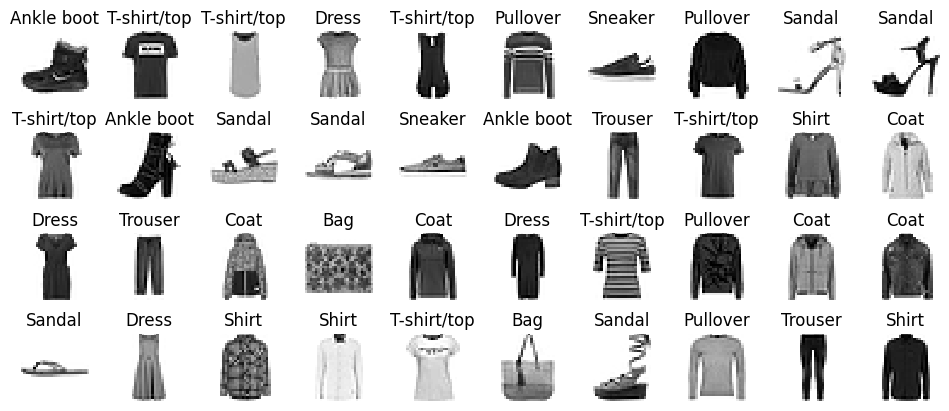

In [34]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(train_data.data[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[train_data.targets[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Load data


In [35]:
# setup the batch size hyperparameter
BATCH_SIZE = 32

# turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, #datset to turn into iterable
                              batch_size=BATCH_SIZE,
                              shuffle=True # suhffle data every epochs
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # don't necessarily have to shuffle the testing data


In [36]:
# check out what's inside the training data loader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Baseline Model V-0

In [37]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [38]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names))

model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [39]:
# setup helper functions
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [40]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=1e-1)

In [41]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [42]:
torch.manual_seed(42)

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: nan | Train accuracy: 9.99%
Test loss: nan | Test accuracy: 9.98%

Epoch: 1
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 2
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 3
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 4
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 5
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 6
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 7
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 8
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%

Epoch: 9
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 9.98%



In [43]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [44]:
# Calculate model 1 results with device-agnostic code 
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': nan,
 'model_acc': 9.984025559105431}

In [45]:
# save model
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories
                 exist_ok=True # if models directory already exists
)

# Create model save path
MODEL_NAME = "Baseline_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\Baseline_Model.pth


In [89]:
# Create a new instance of FashionMNISTModelV0
# Note: loading model will error if the shapes here aren't the same as the saved version
from baseline import FashionMNISTModelV0
loaded_model_0 = FashionMNISTModelV0(input_shape=28*28, 
                                    hidden_units=10, # dont change parameter -> error 
                                    output_shape=len(class_names)) 

# Load in the saved state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_0 = loaded_model_0.to(device)

In [85]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_0_results = eval_model(
    model=loaded_model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': nan,
 'model_acc': 9.984025559105431}

# Visualize prediction result

In [86]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [87]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [102]:
# Make predictions on test samples with model 0
pred_probs= make_predictions(model=loaded_model_0, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [81]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [82]:
# Are our predictions in the same form as our test labels
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))

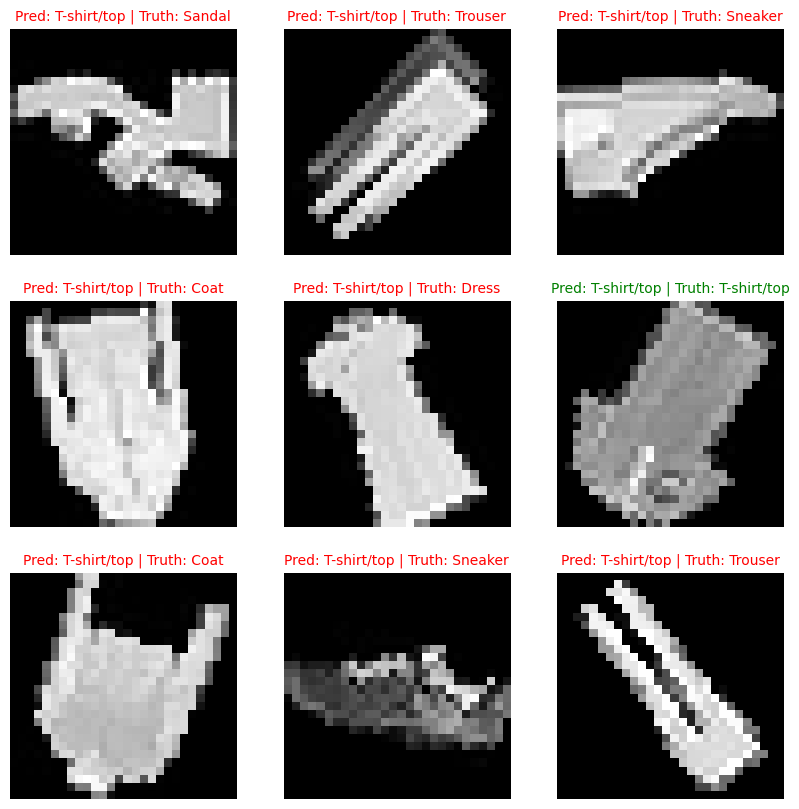

In [83]:
# Plot predictions
plt.figure(figsize=(10,10 ))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

# VGG Model V-1

In [54]:
# Create a convolutional neural network 
class FashionMNISTModelV1(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [55]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [56]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                             lr=0.1)

In [57]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [59]:
torch.manual_seed(42)
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64179 | Train accuracy: 76.74%
Test loss: 1.19482 | Test accuracy: 58.84%

Epoch: 1
---------
Train loss: 0.62375 | Train accuracy: 77.47%
Test loss: 0.62646 | Test accuracy: 77.51%

Epoch: 2
---------
Train loss: 0.61539 | Train accuracy: 77.86%
Test loss: 0.62129 | Test accuracy: 76.99%

Epoch: 3
---------
Train loss: 0.60614 | Train accuracy: 78.22%
Test loss: 0.59678 | Test accuracy: 78.55%

Epoch: 4
---------
Train loss: 0.59697 | Train accuracy: 78.36%
Test loss: 0.60303 | Test accuracy: 78.34%

Epoch: 5
---------
Train loss: 0.59502 | Train accuracy: 78.64%
Test loss: 0.65449 | Test accuracy: 76.39%

Epoch: 6
---------
Train loss: 0.58856 | Train accuracy: 78.87%
Test loss: 0.58776 | Test accuracy: 78.74%

Epoch: 7
---------
Train loss: 0.59289 | Train accuracy: 78.52%
Test loss: 0.59205 | Test accuracy: 78.97%

Epoch: 8
---------
Train loss: 0.58139 | Train accuracy: 79.12%
Test loss: 0.57111 | Test accuracy: 79.98%

Epoch: 9
---------
Train los

In [60]:
# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.616530179977417,
 'model_acc': 77.65575079872204}

In [97]:
# save model
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories
                 exist_ok=True # if models directory already exists
)

# Create model save path
MODEL_NAME = "Model_TinyVgg.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\Model_TinyVgg.pth


In [98]:
# Create a new instance of FashionMNISTModelV0
# Note: loading model will error if the shapes here aren't the same as the saved version
from TinyVggModel import FashionMNISTModelV1
loaded_model_1 = FashionMNISTModelV1(input_shape=1, 
                                    hidden_units=10, 
                                    output_shape=len(class_names)).to(device)
# Load in the saved state_dict()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_1 = loaded_model_1.to(device)

In [99]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [104]:
# Make predictions on test samples with model 0
pred_probs= make_predictions(model=loaded_model_1, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs

tensor([[1.1862e-04, 8.0802e-08, 1.1295e-05, 2.9917e-06, 3.0957e-06, 6.8287e-01,
         1.6475e-05, 2.7703e-01, 2.7136e-03, 3.7234e-02],
        [3.1424e-02, 2.1753e-01, 1.9208e-03, 1.8904e-01, 3.7678e-01, 5.7462e-03,
         1.6785e-01, 3.6112e-04, 9.2184e-03, 1.1908e-04],
        [1.9872e-04, 1.7410e-05, 3.0880e-06, 4.4550e-07, 1.0093e-05, 2.1591e-02,
         4.6453e-06, 3.1792e-01, 5.0334e-04, 6.5975e-01],
        [2.7382e-03, 2.1481e-03, 1.7321e-02, 2.7608e-02, 9.1014e-01, 7.7010e-06,
         3.9811e-02, 5.9265e-08, 2.2037e-04, 7.7313e-06],
        [2.8400e-02, 7.2360e-05, 2.5449e-05, 9.6068e-01, 2.3393e-04, 1.2059e-03,
         2.7296e-03, 2.6766e-04, 1.3813e-05, 6.3703e-03],
        [7.3708e-01, 9.5759e-05, 3.3221e-04, 1.5083e-02, 1.3111e-03, 7.7614e-05,
         2.4567e-01, 1.3982e-06, 1.1322e-04, 2.3624e-04],
        [1.5998e-04, 6.4677e-06, 3.1202e-03, 1.1593e-03, 9.8493e-01, 8.9864e-07,
         1.0123e-02, 1.7488e-07, 3.6320e-04, 1.3470e-04],
        [3.1331e-05, 2.3898

In [105]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 4, 9, 4, 3, 0, 4, 7, 1])

In [107]:
test_labels,pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 4, 9, 4, 3, 0, 4, 7, 1]))

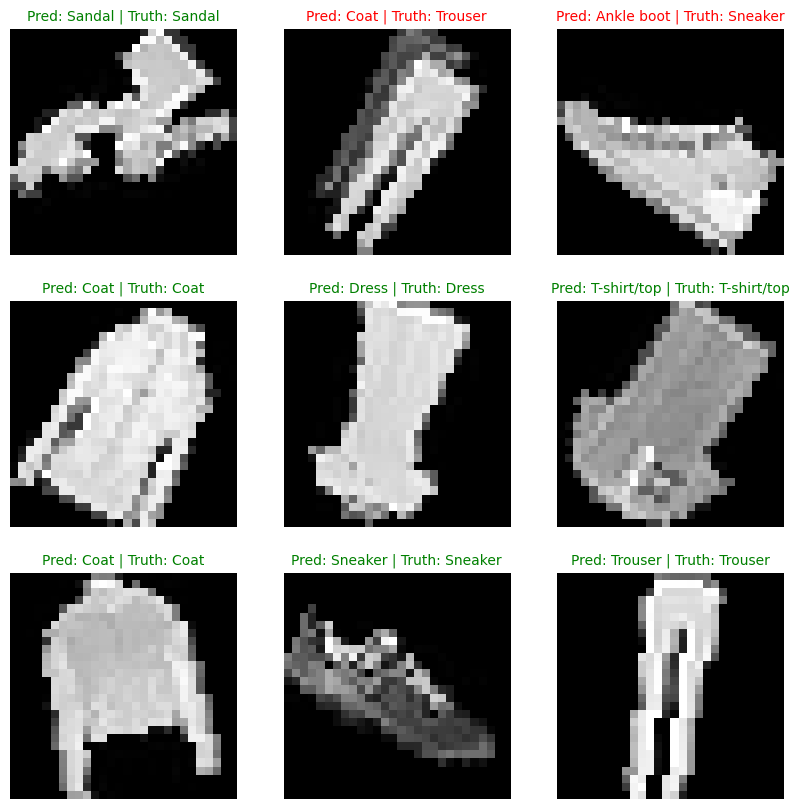

In [108]:
# Plot predictions
plt.figure(figsize=(10,10 ))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)